# Full Managed model deployment using SageMaker Deployment Guardrail
## Introduction
Deployment guardrails are a set of model deployment options in Amazon SageMaker Inference to update your machine learning models in production. Using the **fully managed** deployment options, you can control the switch from the current model in production to a new one. 

## BLUE/GREEN Deployment
Traffic shifting modes in blue/green deployments, such as canary and linear, give you granular control over the traffic shifting process from your current model to the new one during the course of the update. There are also built-in safeguards such as auto-rollbacks that help you catch issues early and automatically take corrective action before they significantly impact production.

In this lab, we'll leverage SageMaker deployment guardrail feature to perform continue deployment using Canary deployment strategy. Specifically, the following steps will be performed:

1. Deploy a baseline model to a SageMaker endpoint
2. Define a Canary deployment configuration in JSON format
3. Deploy a new version of a model with errors to the same SageMaker endpoint
4. Perform inferences on the new version of the model
5. Observe the rollback action triggered by Cloudwatch alarm
6. Deployment a new version of a model without any errors to the same SageMaker endpoiont.
7. Perform inference on the new version of the model
8. Observe a successful deployment

Let's get started!

Importing the required dependencies

In [1]:
import sagemaker
from sagemaker.s3 import S3Uploader
from sagemaker import image_uris
import boto3
from datetime import datetime
import time
import json
from PIL import Image
import io

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
sess = sagemaker.session.Session()
sm = boto3.client("sagemaker")
sm_runtime = boto3.client("sagemaker-runtime")

In [3]:
prefix = "models/xgb-churn-prediction-model"
bucket = sess.default_bucket()  # bucket to house artifacts
role = sagemaker.get_execution_role()  # execution role for the endpoint

### Model artifacts
The example we use here is based on a Churn prediction model trained on a public dataset that predicts Mobile Customer Departure. 

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets. 

This particular churn prediction model a binary classification model, trained using Xgboost. The complete step for training the model using the dataset can be found [here](xgboost_customer_churn.ipynb).

Since the objective for this lab is on the deployment guardrail, we'll use a pretrained model provided in this lab so that we don't need to go through the training process which could be time consuming.

However, feel free to run the [notebook](xgboost_customer_churn.ipynb), or make any modifications to adapt to your use case accordingly.

In [4]:
model_url = S3Uploader.upload(local_path="model/xgb-churn-prediction-model.tar.gz",
desired_s3_uri=f"s3://{bucket}/{prefix}")

model_url2 = S3Uploader.upload(local_path="model/xgb-churn-prediction-model2.tar.gz",
desired_s3_uri=f"s3://{bucket}/{prefix}")

In [5]:
image_uri = image_uris.retrieve('xgboost', boto3.Session().region_name, '0.90-1')

# using newer version of XGBoost which is incompatible, in order to simulate model faults
image_uri2 = image_uris.retrieve('xgboost', boto3.Session().region_name, '1.2-1')
image_uri3 = image_uris.retrieve('xgboost', boto3.Session().region_name, '0.90-2')

## Deploy a Model in SageMaker
### Create a SageMaker Model
In the following section, we create our model definitions. We start with deploying the pre-trained churn prediction models. Here, we create the model objects with the image and model data. The three URIs correspond to the baseline version, an incompatible version, and a correct new model version.

In [6]:
model_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}" 
model_name2 = f"DEMO-xgb-churn-pred2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name3 = f"DEMO-xgb-churn-pred3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

resp = sm.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    Containers=[{
       'Image': image_uri,
       'ModelDataUrl': model_url
     }])

resp = sm.create_model(
    ModelName=model_name2,
    ExecutionRoleArn=role,
    Containers=[{
       'Image':image_uri2,
       'ModelDataUrl': model_url2
     }])

resp = sm.create_model(
    ModelName=model_name3,
    ExecutionRoleArn=role,
    Containers=[{
       'Image':image_uri3,
       'ModelDataUrl': model_url2
     }])

### Create a SageMaker Model Configuration
Next, we'll create the endpoint configurations associated with the model objects created in the previous step.

In [7]:
ep_config_name = f"DEMO-EpConfig-1-{datetime.now():%Y-%m-%d-%H-%M-%S}" 
ep_config_name2 = f"DEMO-EpConfig-2-{datetime.now():%Y-%m-%d-%H-%M-%S}" 
ep_config_name3 = f"DEMO-EpConfig-3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

resp = sm.create_endpoint_config(
     EndpointConfigName=ep_config_name,
     ProductionVariants=[
        {
          'VariantName': "AllTraffic",
          'ModelName': model_name,
          'InstanceType': "ml.m5.xlarge",
          "InitialInstanceCount": 2
        }
      ])

resp = sm.create_endpoint_config(
     EndpointConfigName=ep_config_name2,
     ProductionVariants=[
        {
          'VariantName': "AllTraffic",
          'ModelName': model_name2,
          'InstanceType': "ml.m5.xlarge",
          "InitialInstanceCount": 2
        }
      ])


resp = sm.create_endpoint_config(
      EndpointConfigName=ep_config_name3,
      ProductionVariants=[
         {
           'VariantName': "AllTraffic",
           'ModelName': model_name3,
           'InstanceType': "ml.m5.xlarge",
           "InitialInstanceCount": 2
         }
     ])

## Create a SageMaker Model endpoint
In the following, we'll deploy the first model as a SageMaker endpoint. This model will be used as our baseline production model.

In [8]:
endpoint_name = model_name
resp = sm.create_endpoint(
          EndpointName=endpoint_name,
          EndpointConfigName=ep_config_name
)

Wait for the status to be ready

In [9]:
def wait_for_endpoint_in_service(endpoint_name):
    endpoint_deployment_status = ""
    while True:
        response = sm.describe_endpoint(EndpointName=endpoint_name)
        endpoint_deployment_status = response['EndpointStatus']
        if endpoint_deployment_status in ["OutOfService", "InService", "Failed", "UpdateRollbackFailed"]:
            break
        print(f"Deployment status: {endpoint_deployment_status}")
        time.sleep(20)
    print(f"Final Deployment status: {endpoint_deployment_status}")

In [10]:
wait_for_endpoint_in_service(endpoint_name)

Deployment status: Creating
Deployment status: Creating
Deployment status: Creating
Deployment status: Creating
Deployment status: Creating
Deployment status: Creating
Deployment status: Creating
Deployment status: Creating
Deployment status: Creating
Final Deployment status: InService


## Simulate Inference Traffic
After a successful model deployment, we will start sending requests to the SageMaker endpoint. 
We'll be using the sample data provided in this lab. We'll also capture the status of the requests to help us understand the state of the endpoint throughout the deployment process. 

Define a helper function that invoke the model to predict churn on every entry in the test dataset.

In [11]:
def invoke_endpoint(endpoint_name, max_invocations=300, wait_interval_sec=1, should_raise_exp=False):
    print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

    count = 0
    with open('test_data/test.csv', 'r') as f:
        for row in f:
            payload = row.rstrip('\n')
            try:
                response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                                      ContentType='text/csv',
                                                      Body=payload)
                response['Body'].read()
                print(".", end="", flush=True)
            except Exception as e:
                print("E", end="", flush=True)
                if should_raise_exp:
                    raise e
            count += 1
            if count > max_invocations:
                break
            time.sleep(wait_interval_sec)

    print("\nDone!")

In [12]:
invoke_endpoint(endpoint_name, max_invocations=100)

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2024-03-21-15-48-28. 
Please wait...
.....................................................................................................
Done!


## Monitor SageMaker endpoint using Cloudwatch Metrics
By default, SageMaker hosting service provides various metrics that allow you to monitor the health of the endpoints. All metrics are hosted in CloudWatch Metrics. The default metrics from SageMaker are described in the following:

### SageMaker Endpoint Invocation Metrics

* **Cloudwatch Metric namespace:** AWS/SageMaker
* **Metrics Frequency:** 1-minute.
* **Network latency:** The time that it takes between making a request to the SageMaker Runtime Runtime API and receiving a response back from the SageMaker Runtime Runtime API.
* **Overhead latency:** The time that it takes to transport a request to the model container from the SageMaker Runtime Runtime API and transport the response back to the SageMaker Runtime Runtime API.
* **Model latency** The time that it takes the model container to process the request and return a response.
* **Invocation4XXErrors** The number of InvokeEndpoint requests where the model returned a 4xx HTTP response code.
* **Invocation5XXErrors:** The number of InvokeEndpoint requests where the model returned a 5xx HTTP response code. 
* **InvocationModelErrors** - The number of model invocation requests which did not result in 2XX HTTP response.

The following diagram depicts the network traffic pattern and the associated latency from the origin to SageMaker endpoint. 

![CW SageMaker metrics](images/sm-cw-metrics.jpg)

Please refer to this [blog](https://aws.amazon.com/blogs/machine-learning/best-practices-for-load-testing-amazon-sagemaker-real-time-inference-endpoints/) to learn more about the total endpoint latency.

Let's visualize these metrics in the following section

In [14]:
cw_client = boto3.client("cloudwatch")

In [15]:
def display_cw_metrics(metric_dims, endpoint_name, endpoint_config_names):
    images = []
    for metric_dim in metric_dims:
        stat = "Sum"
        if "Latency" in metric_dim:
            stat = "Average"

        metrics = []
        for endpoint_config_name in endpoint_config_names:
            metrics.append([ "AWS/SageMaker", metric_dim, "EndpointName", endpoint_name, "VariantName", "AllTraffic", "EndpointConfigName", endpoint_config_name])
            
        metric_widget = {
            "metrics": metrics,
            "view": "timeSeries",
            "stacked": False,
            "stat": stat,
            "period": 60,
            "width": 1000,
            "height": 200,
            "start": "-PT1H",
            "end": "P0D"
        }
        response = cw_client.get_metric_widget_image(
            MetricWidget=json.dumps(metric_widget)
        )
        images.append(Image.open(io.BytesIO(response["MetricWidgetImage"])))
    for image in images:
        image.show()

In the following section, we visualize the relevant cloudwatch metrics. We will focus on the metrics around invocation counts, server/client errors and model latency. 

Here are the metrics:

* Invocations
* Invocation4XXErrors
* Invocation5XXErrors
* ModelLatency
* OverheadLatency
* 

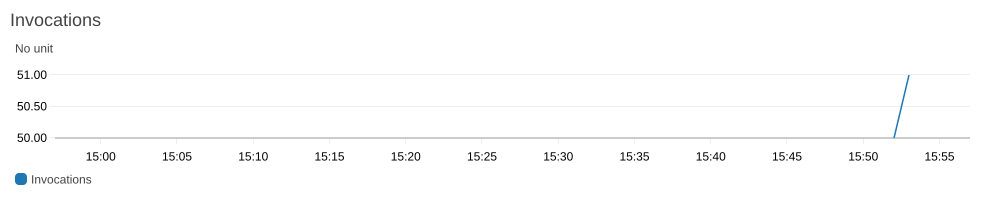

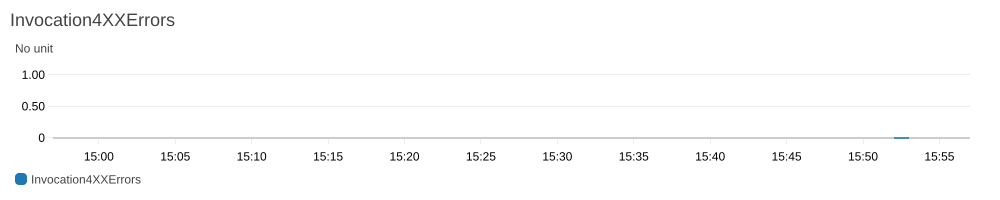

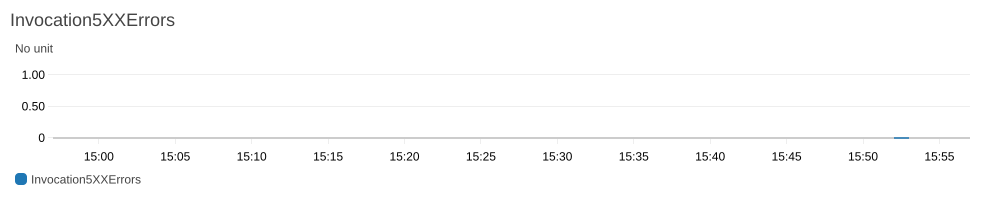

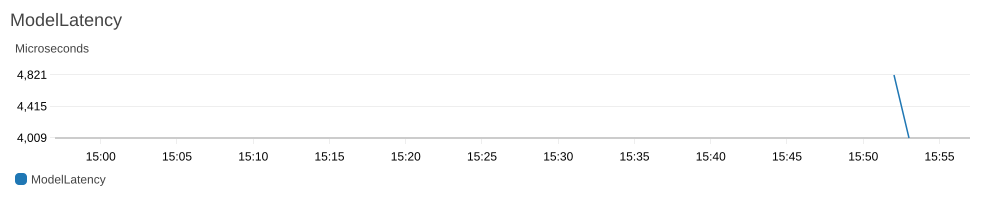

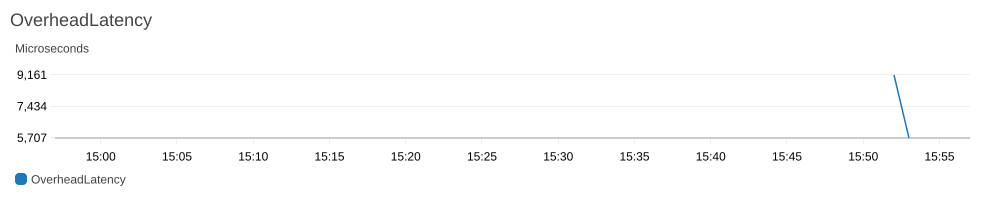

In [17]:
metric_dims = ["Invocations", "Invocation4XXErrors", "Invocation5XXErrors", "ModelLatency", "OverheadLatency"]
ep_config_names = [ep_config_name]
display_cw_metrics(metric_dims, endpoint_name, ep_config_names)

## Monitor SageMaker Endpoint Performance
In the following section, we are going to monitor the endpoint performance by setting up some custom Cloudwatch Alarms. We will use these alarm with actions if the endpoint is not functioning as expected.

In our example, the action for the alarm would be to rollback the endpoint automatically. 

In [18]:
def create_auto_rollback_alarm(alarm_name, endpoint_name, variant_name, metric_name, statistic, threshold):
    cw_client.put_metric_alarm(
        AlarmName=alarm_name,
        AlarmDescription='Test SageMaker endpoint deployment auto-rollback alarm',
        ActionsEnabled=False,
        Namespace='AWS/SageMaker',
        MetricName=metric_name,
        Statistic=statistic,
        Dimensions=[
            {
            'Name': 'EndpointName',
            'Value': endpoint_name
            },
            {
            'Name': 'VariantName',
            'Value': variant_name
            }
        ],
        Period=60,
        EvaluationPeriods=1,
        Threshold=threshold,
        ComparisonOperator='GreaterThanOrEqualToThreshold',
        TreatMissingData='notBreaching'
        )

Let's set an automatic rollback alarms as followed:

In [19]:
# alarm on 1% 5xx error rate for 1 minute
create_auto_rollback_alarm("error_alarm", endpoint_name, 'AllTraffic', 'Invocation4XXErrors', 'Sum', 1)
# alarm on model latency >= 10 ms for 1 minute
create_auto_rollback_alarm("latency_alarm", endpoint_name, 'AllTraffic', 'ModelLatency', 'Average', 10000)


### Setup Blue/Green Deployment
So far, we have deployed a single endpoint with test traffics. We have also created some alarms for the endpoint so that if the defined threshold is exceed, it'll trigger a rollback automatically.  

SageMaker deployment guardrail supports 3 types of BLUE/GREEN deployment strategies: 

* All at once
* Canary
* Linear 

The following detail describes in greater detail for each deployment strategy and discuss the advantage/disadvantages for each strategy. 

| Name | What is it | Pros | Cons | Recommendation |
|:--------:|:--------:|:--------:|:--------:|:--------:|
| All at once | Shifts all of the traffic to the new fleet in a single step. | Minimizes the overall update duration. | Regressive updates affect 100% of the traffic. | Use this option to minimize update time and cost. |
| Canary | Traffic shifts in two steps. The first (canary) step shifts a small portion of the traffic followed by the second step, which shifts the remainder of the traffic. | Confines the blast radius of regressive updates to only the canary fleet. | Both fleets are operational in parallel for entire deployment. | Use this option to balance between minimizing the blast radius of regressive updates and minimizing the time that two fleets are operational. |
| Linear | A fixed portion of the traffic shifts in a pre-specified number of equally spaced steps. | Minimizes the risk of regressive updates by shifting traffic over several steps. | The update duration and cost are proportional to the number of steps. | Use this option to minimize risk by spreading out deployment across multiple steps. |

### Canary Deployment Strategy
In the next section, we'll adopt the canary deployment strategy and observe the effects in action. To simulate a BLUE/GREEN deployment, we'll deploy another endpoint following deployment configuration with traffic shifting from the old to the new stack. 

The following diagram depicts the expected bahavior when errors are encountered during the BLUE/GREEN Canary deployment process:

![sm-deployment-guardrail-canary](images/sm-deployment-guardrail-rollback-canary.jpg)

## Deployment Configuration

First, we need to define a deployment config. The parameters are described in the following:

* **EndpointName**: The name of the existing endpoint you want to update.
* **EndpointConfigName**: The name of the endpoint configuration you want to use.
* **BlueGreenUpdatePolicy**: Define the type of deployment option. For example, CANARY, ALL_AT_ONCE or LINEAR.
* **CanarySize**: Batch size for the first step to turn on traffic on the new endpoint fleet. Value must be less than or equal to 50% of the variant's total instance count. This could be a percentage of the capacity, or instance count.
* **WaitIntervalInSeconds**: The waiting time (in seconds) between incremental steps to turn on traffic on the new endpoint fleet.
* **TerminationWaitInSeconds**: Additional waiting time in seconds after the completion of an endpoint deployment before terminating the old endpoint fleet.
* **MaximumExecutionTimeoutInSeconds**: Maximum execution timeout for the deployment. The timeout value should be larger than the total waiting time specified in TerminationWaitInSeconds and WaitIntervalInSeconds.
* **AutoRollbackConfiguration**: Automatic rollback configuration for handling endpoint deployment failures and recovery. This is where you can add your CloudWatch alarms by name. 

In [20]:
canary_deployment_config = {
    "BlueGreenUpdatePolicy": {
        "TrafficRoutingConfiguration": {
            "Type": "CANARY",
            "CanarySize": {
                "Type": "INSTANCE_COUNT", # or use "CAPACITY_PERCENT" as 30%, 50%
                "Value": 1
            },
            "WaitIntervalInSeconds": 180, # wait for 5 minutes before enabling traffic on the rest of fleet
        },
        "TerminationWaitInSeconds": 120, # wait for 2 minutes before terminating the old stack
        "MaximumExecutionTimeoutInSeconds": 1800 # maximum timeout for deployment
    },
    "AutoRollbackConfiguration": {
        "Alarms": [
            {
                "AlarmName": "error_alarm"
            },
            {
                "AlarmName": "latency_alarm"
            }
        ],
    }
}

Update endpoint request with new DeploymentConfig parameter

In [21]:
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name2,
    DeploymentConfig=canary_deployment_config
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:713596524138:endpoint/DEMO-xgb-churn-pred-2024-03-21-15-48-28',
 'ResponseMetadata': {'RequestId': '6a11fcbf-e6e7-4e66-b751-fe142fbddb0c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6a11fcbf-e6e7-4e66-b751-fe142fbddb0c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '107',
   'date': 'Thu, 21 Mar 2024 15:58:06 GMT'},
  'RetryAttempts': 0}}

## Simulate SageMaker Inference fraffic of a FAILED Canary Deployment
Similar to the deployed base model, we will start sending requests to the SageMaker endpoint with a new endpoint configuration and deployment strategy configuration applied to it. We'll also capture the status of the requests to help us understand the state of the endpoint throughout the deployment process.

In [22]:
invoke_endpoint(endpoint_name, max_invocations=600)

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2024-03-21-15-48-28. 
Please wait...
.....................................................................................................................................................................................EE......E.EEEE.EEEEE..EEE.E.....E..E..E..E.EE..EE..EEEEEE.E.E....E.EEEEE.EE.E.EEEEE..EEE.EEE....E.E.EE...EEE.EEE.EEE.EE.EE.....EE.EEE...EEE....E.EEEEE........EEE.EE..EEE.E..E...EEEEE.E..EEE..EEE.EEE.E...E..E.EE.E.EE....EE.E..E..................................................................................................................................................................................................
Done!


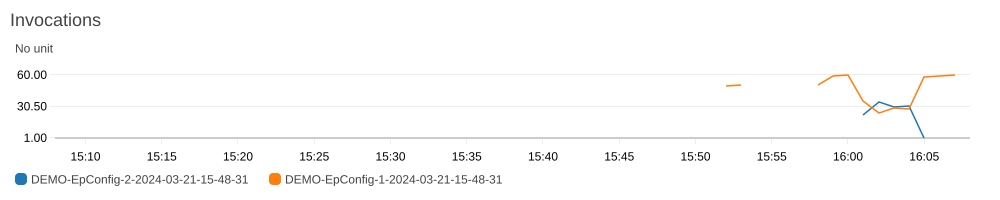

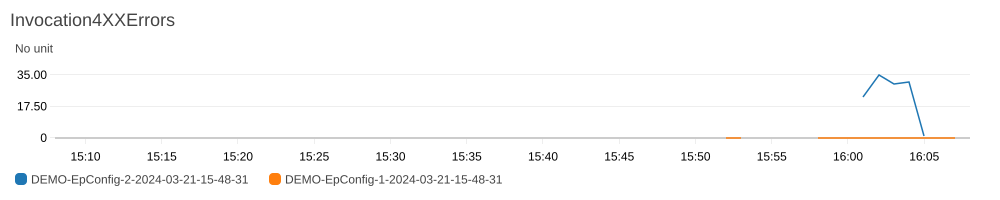

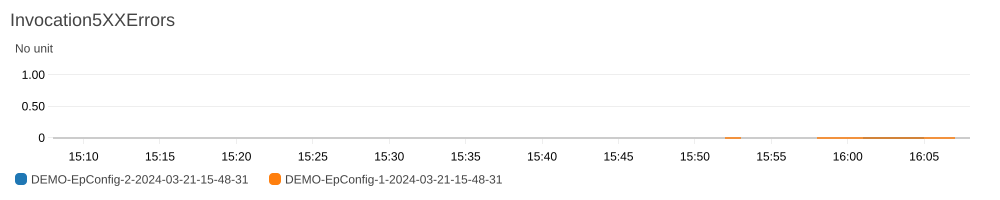

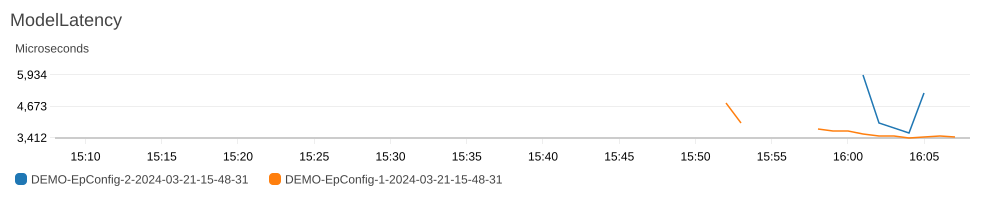

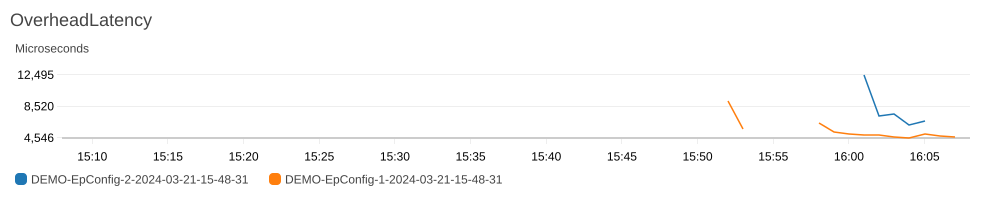

In [23]:
ep_config_names.append(ep_config_name2)
display_cw_metrics(metric_dims, endpoint_name, list(set(ep_config_names)))

## Cloudwatch Alarm Status change
In the following section, we'll examine the status cloudwatch alarm changed when the threshold was exceed. 
The alarm triggered an action for SageMaker deployment guardrail to initiate the rollback action.

The alarm would finally return to the OK state after the rollback is complete. 

In [24]:
def display_cw_metric_alarm(alarm_name, endpoint_name):
    metric_widget = {
        "metrics": [
            [ "AWS/SageMaker", "Invocation4XXErrors", "EndpointName", endpoint_name, 
             "VariantName", "AllTraffic", { "stat": "Sum" } ]
        ],
        "view": "timeSeries",
        "stacked": False,
        "period": 60,
        "title": alarm_name,
        "annotations": {
            "horizontal": [
                {
                    "label": "Invocation4XXErrors >= 1 for 1 datapoints within 1 minute",
                    "value": 1
                }
            ]
        },
        "width": 1201,
        "height": 200,
        "start": "-PT3H",
        "end": "P0D"
    }
    response = cw_client.get_metric_widget_image(
        MetricWidget=json.dumps(metric_widget)
    )
    image = Image.open(io.BytesIO(response["MetricWidgetImage"]))
    image.show()

In [25]:
response = cw_client.describe_alarm_history(
    AlarmName='error_alarm',
    AlarmTypes=['MetricAlarm'],
    HistoryItemType='StateUpdate',
    StartDate=datetime(2015, 1, 1),
    EndDate=datetime(2024, 12, 31),
    ScanBy='TimestampDescending'
)

In [26]:
for alarm_state in [(x['Timestamp'].strftime("%m/%d/%Y, %H:%M:%S"), x['HistorySummary']) for x in response['AlarmHistoryItems']]:
    print(alarm_state)

('03/21/2024, 16:04:10', 'Alarm updated from OK to ALARM')
('03/21/2024, 15:59:10', 'Alarm updated from INSUFFICIENT_DATA to OK')


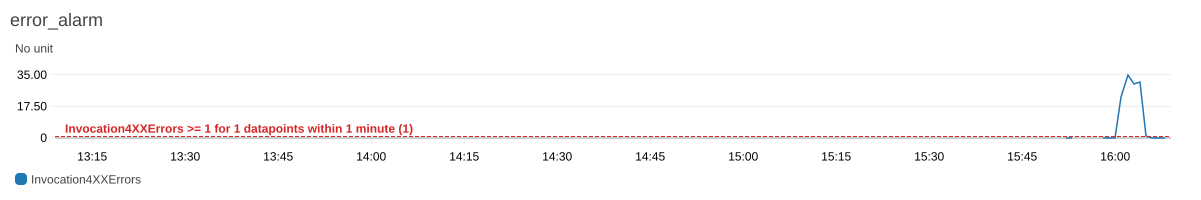

In [27]:
display_cw_metric_alarm("error_alarm", endpoint_name)

### Successful Canary Deployment
In the following section, we'll perform the deployment process again, the difference is this time we update the endpoint configuration to a valid version. We'll reuse the same canary deployment config as the rollback case.

The following diagram depicts a successful Canary deployment scenario:
![successful canary deployment](images/sm-deployment-guardrail-canary-success.jpg)

In [28]:
# update endpoint with a valid version of DeploymentConfig
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name3,
    RetainDeploymentConfig=True # Reuse the same deployment configuration
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:713596524138:endpoint/DEMO-xgb-churn-pred-2024-03-21-15-48-28',
 'ResponseMetadata': {'RequestId': '3da9403a-180e-40b8-978b-e13351a8d947',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3da9403a-180e-40b8-978b-e13351a8d947',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '107',
   'date': 'Thu, 21 Mar 2024 16:09:20 GMT'},
  'RetryAttempts': 0}}

## Simulate SageMaker Inference traffic of a succesful deployment
Similar to the failed deployment in the previous section, we will start sending requests to the SageMaker endpoint with a new endpoint configuration. This time, we expect the deployment to be successful. We'll also capture the status of the requests to help us understand the state of the endpoint throughout the deployment process.

In [29]:
invoke_endpoint(endpoint_name, max_invocations=600)

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2024-03-21-15-48-28. 
Please wait...
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................E..........................................................................
Done!


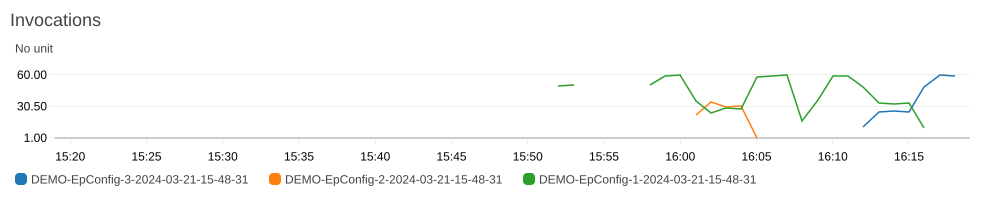

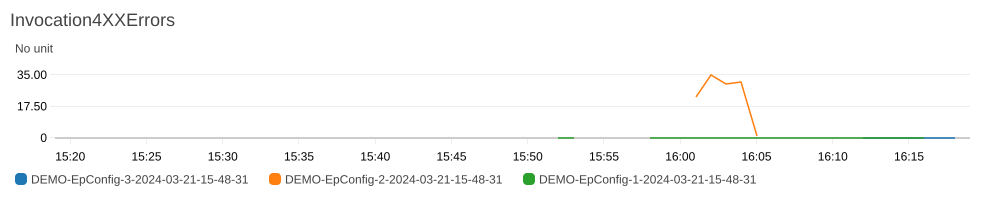

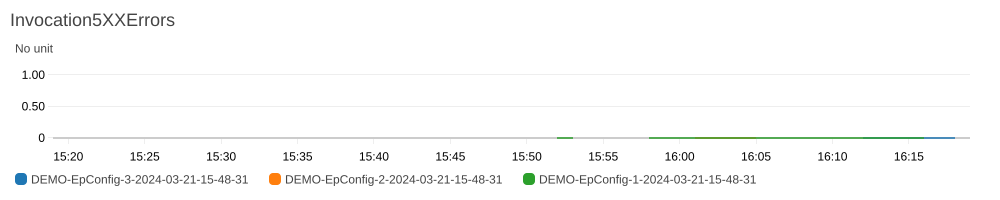

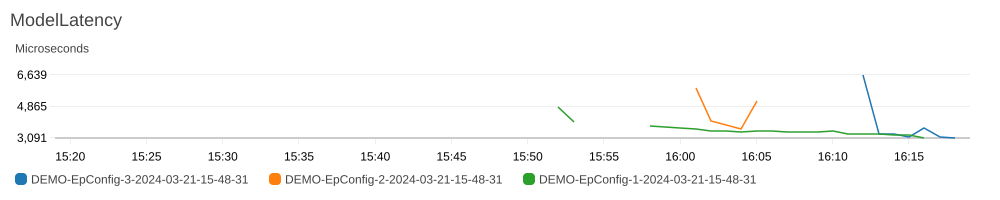

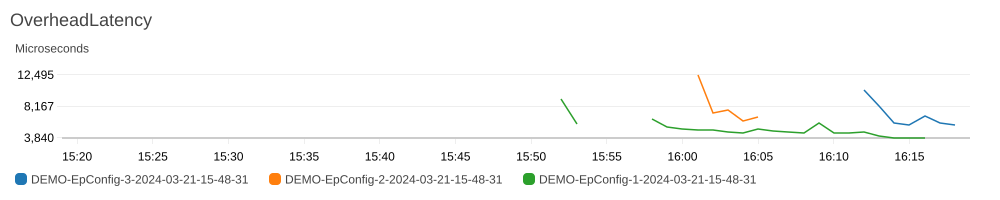

In [30]:
ep_config_names.append(ep_config_name3)
display_cw_metrics(metric_dims, endpoint_name, list(set(ep_config_names)))

Similar to the rollback example, let's examine the alarm state for this deployment:

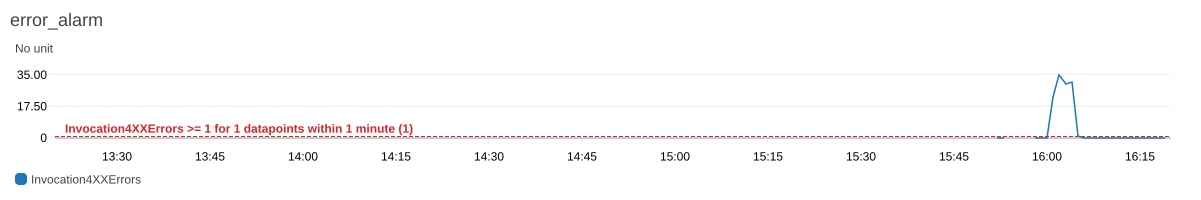

In [31]:
display_cw_metric_alarm("error_alarm", endpoint_name)

# Conclusion
In this lab, we learn how to leverage SageMaker Deployment Guardrail to manage the BLUE/GREEN deployment process.
We started by deploying a valid endpoint, then ran tests against the endpoint to validate the deployment working as expected. 

After a successful test, we created a set of cloudwatch alarms, along with a deployment configuration to setup a canary deployment strategy. 

To validate the canary deployment, we deployed a model that contains errors to simulate a rollback scenario. We validated through Cloudwatch metrics that SageMaker deployment guardrail was able rollback the deployment to a previous version after the cloudwatch alarm was triggered. 

Lastly, we deployed a new version of the model without any errors to similate a successful deployment. We validated through Cloudwatch metrics that SageMaker deployment guardrail was able to sucessfully shift all traffic to the new model, completing the new deployment process.

# Clean up

In [32]:
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '30f51fbb-4340-401a-81db-c85f13dc0cd5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '30f51fbb-4340-401a-81db-c85f13dc0cd5',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 21 Mar 2024 16:20:10 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}